In [ ]:
# 필요한 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import ADASYN # doctest: +NORMALIZE_WHITESPACE
import torch.optim as optim

In [9]:
# BaseModel 클래스 정의 (임베딩 차원 및 모델 구조 간소화)
class BaseModel(nn.Module):
    def __init__(self, encoding_dim, cat_features, num_features, num_classes, cat_cardinalities):
        super(BaseModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality+1, min(10, (cardinality + 1) // 2)) # other 처리하기 위한 임베딩
            for cardinality in cat_cardinalities
        ])
        embedding_output_dim = sum([embedding.embedding_dim for embedding in self.cat_embeddings])
        input_dim = embedding_output_dim + len(num_features)
        self.fc_cat = nn.Linear(input_dim, 64)
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x_cat, x_num):
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        x = torch.cat([x_cat_embedded, x_num], dim=1)
        x = self.fc_cat(x)
        encoded = self.encoder(x)
        out = self.classifier(encoded)
        return out


In [10]:
# 카디널리티 축소 함수 정의
def reduce_cardinality(data, column, threshold=10):
    value_counts = data[column].value_counts()
    categories_to_keep = value_counts[value_counts >= threshold].index
    data[column] = data[column].apply(lambda x: x if x in categories_to_keep else 'Other')
    return data

In [11]:
def encode_and_standardize_data(data, mode, label_encoders=None, scaler=None, min_values=None):
    if 'Is Fraud?' in data.columns:
        data = data.drop('Is Fraud?', axis=1)

    continuous_columns = [
        'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month', 'Per Capita Income - Zipcode',
        'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Year', 'Month', 'Day', 'Amount',
        'Year PIN last Changed'
    ]
    categorical_columns = ['Card Brand', 'Card Type', 'Expires', 'Acct Open Date', 'Error Message']

    # 'Error Message' 변수의 카디널리티 축소 또는 제거
    if mode == 'Train':
        data = reduce_cardinality(data, 'Error Message', threshold=10)
    else:
        data['Error Message'] = data['Error Message'].apply(lambda x: x if x in label_encoders['Error Message'].classes_ else 'Other')

    # 수치형 변수의 결측치는 평균으로 대체
    data[continuous_columns] = data[continuous_columns].fillna(data[continuous_columns].mean())

    # 범주형 변수의 결측치는 최빈값으로 대체
    data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

    # 레이블 인코더 초기화
    if mode == 'Train':
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            data[col] = data[col].astype(str)
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    else:
        # 범주형 변수 인코딩 (테스트 데이터의 새로운 값을 'Other'로 매핑)
        for col in categorical_columns:
            le = label_encoders[col]
            # 'Other'가 없는 경우 클래스 추가
            if 'Other' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'Other')
            # 테스트 데이터에 새로운 값은 'Other'로 매핑
            data[col] = data[col].apply(lambda s: s if s in le.classes_ else 'Other')
            # 인코딩
            data[col] = le.transform(data[col])

    # 추가 범주형 피처 처리
    # 'Has Chip'
    data['Has Chip'] = np.where(data['Has Chip'] == True, 1, 0)
    categorical_columns += ['Has Chip']

    # 연속형 피처에서 최소값 빼기
    if mode == 'Train':
        min_values = {}
        for col in ['Birth Year', 'Year PIN last Changed']:
            min_values[col] = data[col].min()
            data[col] = data[col] - min_values[col]
    else:
        for col in ['Birth Year', 'Year PIN last Changed']:
            data[col] = data[col] - min_values[col]

    # 스케일러 적용
    if mode == 'Train':
        scaler = StandardScaler()
        data[continuous_columns] = scaler.fit_transform(data[continuous_columns])
    else:
        data[continuous_columns] = scaler.transform(data[continuous_columns])



    if mode == 'Test':  # 테스트 데이터 전처리의 마지막 단계
        for i, col in enumerate(categorical_columns):
            if col == 'Has Chip':  # 'Has Chip'은 0/1로 변환되었으므로 스킵
                continue
            max_index = label_encoders[col].classes_.size - 1  # 학습 데이터 기준 최대 인덱스
            data[col] = data[col].apply(lambda x: min(x, max_index))


    # 범주형 피처의 카디널리티 계산
    if mode == 'Train':
        cat_cardinalities = [data[col].nunique() for col in categorical_columns]
    else:
        cat_cardinalities = None

    # 피처 분할
    cat_features = data[categorical_columns].astype(int)
    num_features = data[continuous_columns]

    if mode == 'Train':
        return cat_features, num_features, cat_cardinalities, label_encoders, scaler, min_values
    else:
        return cat_features, num_features


In [12]:

# 데이터 로드 및 전처리
train_data = pd.read_csv('data/train.csv')
y_train = train_data['Is Fraud?']
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)

x_cat_train, x_num_train, cat_cardinalities_train, label_encoders, scaler, min_values = encode_and_standardize_data(
    train_data, mode='Train'
)

x_resampled, y_resampled = pd.concat([x_cat_train,x_num_train],axis=1), y_train_encoded

x_cat_train_resampled = x_resampled[x_cat_train.columns]
x_num_train_resampled = x_resampled[x_num_train.columns]
y_train_resampled = y_resampled


In [13]:
# Tensor로 변환
x_cat_train_tensor = torch.tensor(x_cat_train_resampled.values, dtype=torch.long)
x_num_train_tensor = torch.tensor(x_num_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

# 테스트 데이터 전처리
test_data = pd.read_csv('data/test.csv')
x_cat_test, x_num_test = encode_and_standardize_data(
    test_data, mode='Test', label_encoders=label_encoders, scaler=scaler, min_values=min_values
)
x_cat_test_tensor = torch.tensor(x_cat_test.values, dtype=torch.long)
x_num_test_tensor = torch.tensor(x_num_test.values, dtype=torch.float32)

# 데이터셋 분할
X = pd.concat([x_cat_train_resampled, x_num_train_resampled], axis=1)
y = y_train_resampled

X_train, X_val, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
### 여기서 ADASYN 적용 ###
# Train 셋에만 적용한다. Validation, Test에는 적용하지 않는다.
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled_ada = adasyn.fit_resample(X_train, y_train_split)
# 여기까지가 학습 전, Train 데이터에 대한 오버샘플링

NameError: name 'ADASYN' is not defined

In [ ]:
x_cat_train_split = torch.tensor(X_train[x_cat_train.columns].values, dtype=torch.long)
x_num_train_split = torch.tensor(X_train[x_num_train.columns].values, dtype=torch.float32)

x_cat_val_split = torch.tensor(X_val[x_cat_train.columns].values, dtype=torch.long)
x_num_val_split = torch.tensor(X_val[x_num_train.columns].values, dtype=torch.float32)

y_train_split = torch.tensor(y_train_split, dtype=torch.long)
y_val_split = torch.tensor(y_val_split, dtype=torch.long)

In [ ]:
# 데이터셋 정의
train_dataset = torch.utils.data.TensorDataset(x_cat_train_split, x_num_train_split, y_train_split)
val_dataset = torch.utils.data.TensorDataset(x_cat_val_split, x_num_val_split, y_val_split)

# 데이터로더 정의 (배치 크기 증가)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

# 모델 인스턴스 생성
model = BaseModel(
    encoding_dim=32,
    cat_features=x_cat_train.columns,
    num_features=x_num_train.columns,
    num_classes=len(le_target.classes_),
    cat_cardinalities=cat_cardinalities_train
)

# Loss Function, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_cat_batch, x_num_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_cat_batch, x_num_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

        # 검증 루프
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x_cat_batch, x_num_batch, y_batch in val_loader:
                outputs = model(x_cat_batch, x_num_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


In [ ]:
def extract_features(model, x_cat, x_num):
    model.eval()
    with torch.no_grad():
        # 임베딩 레이어 적용
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
        x_cat_embedded = torch.cat(embeddings, dim=1)
        x = torch.cat([x_cat_embedded, x_num], dim=1)
        x = model.fc_cat(x)
        # 인코더를 통과하여 특징 벡터 추출
        features = model.encoder(x)
    return features


In [ ]:
# 학습 실행
train_model(model, train_loader, val_loader, num_epochs=20)

# 테스트 데이터에 대한 예측
model.eval()
with torch.no_grad():
    outputs = model(x_cat_test_tensor, x_num_test_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_labels = le_target.inverse_transform(predicted.cpu().numpy())

# 결과 출력
print(predicted_labels)

Epoch 1/20, Loss: 70.5895
Validation Loss: 11.7941, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 2/20, Loss: 44.0709
Validation Loss: 10.6304, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 3/20, Loss: 39.0165
Validation Loss: 9.9569, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 4/20, Loss: 35.6483
Validation Loss: 9.3974, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 5/20, Loss: 32.9431
Validation Loss: 8.4382, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 6/20, Loss: 30.7491
Validation Loss: 8.1027, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9979
Epoch 7/20, Loss: 28.8895
Validation Loss: 7.7570, Accuracy: 0.9986, Precision: 0.9977, Recall: 0.9986, F1 Score: 0.9979
Epoch 8/20, Loss: 27.8548
Validation Loss: 7.6535, Accuracy: 0.9986, Precision: 0.9978, Recall: 0.9986, F1 Score: 0.9980
Epoch 9/20, Loss: 26.8409
Vali

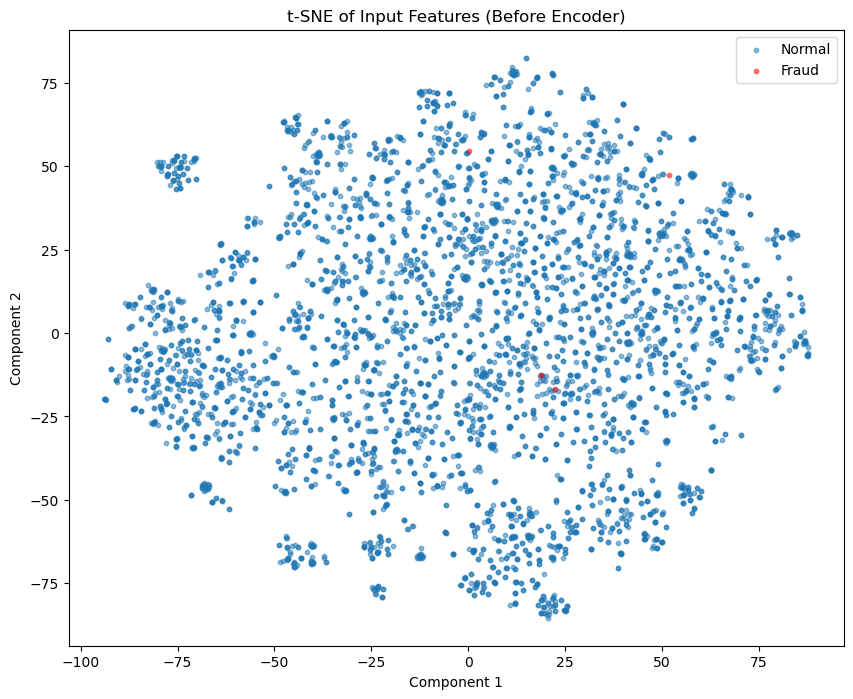

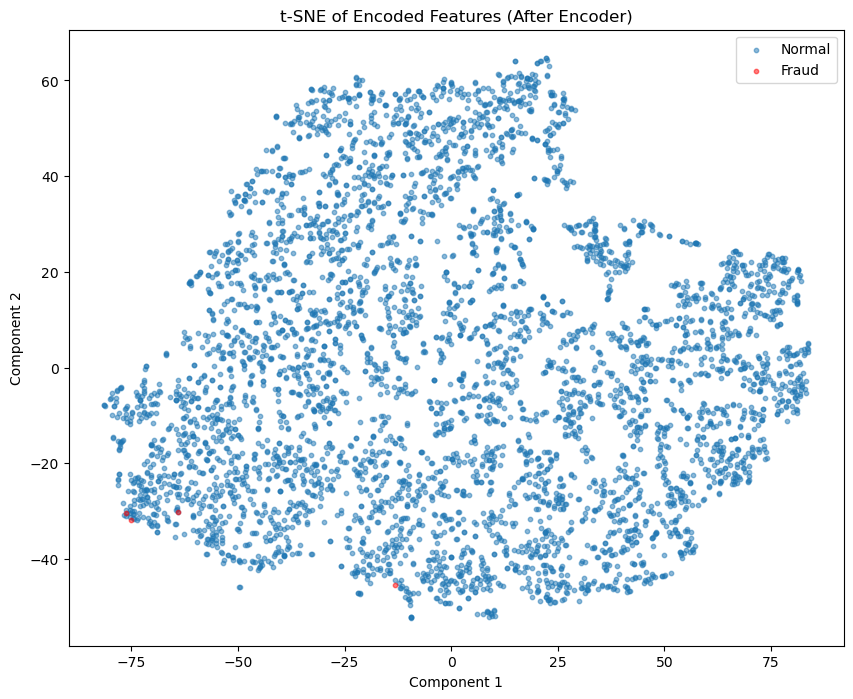

In [ ]:
# # 필요한 라이브러리 임포트
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # 인코더 입력 피처 추출 함수
# def extract_input_features(model, x_cat, x_num):
#     model.eval()
#     with torch.no_grad():
#         # 카테고리형 변수 임베딩
#         embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
#         x_cat_embedded = torch.cat(embeddings, dim=1)
#         # 임베딩된 카테고리형 변수와 수치형 변수 결합
#         x_input = torch.cat([x_cat_embedded, x_num], dim=1)
#     return x_input

# # 인코더 출력 피처 추출 함수
# def extract_encoded_features(model, x_cat, x_num):
#     model.eval()
#     with torch.no_grad():
#         # 카테고리형 변수 임베딩
#         embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
#         x_cat_embedded = torch.cat(embeddings, dim=1)
#         # 임베딩된 카테고리형 변수와 수치형 변수 결합
#         x = torch.cat([x_cat_embedded, x_num], dim=1)
#         x = model.fc_cat(x)
#         # 인코더 통과
#         encoded_features = model.encoder(x)
#     return encoded_features

# # 학습 데이터의 레이블 ('Is Fraud?')
# y_train_labels = y_train_tensor.cpu().numpy()

# # 인코더 입력 피처 추출
# input_features = extract_input_features(model, x_cat_train_tensor, x_num_train_tensor)
# input_features = input_features.cpu().numpy()

# # 데이터 샘플링 (예: 5000개 샘플 사용)
# sample_size = 5000  # 원하는 샘플 크기 설정
# indices = np.random.choice(len(input_features), size=sample_size, replace=False)
# input_features_sample = input_features[indices]
# y_train_labels_sample = y_train_labels[indices]

# # t-SNE 적용 (인코더 입력 피처)
# tsne_input = TSNE(n_components=2, random_state=42)
# input_features_tsne = tsne_input.fit_transform(input_features_sample)

# # 시각화 (인코더 입력 피처)
# plt.figure(figsize=(10, 8))
# fraud_indices = y_train_labels_sample == 1
# normal_indices = y_train_labels_sample == 0

# plt.scatter(input_features_tsne[normal_indices, 0], input_features_tsne[normal_indices, 1],
#             label='Normal', alpha=0.5, s=10)
# plt.scatter(input_features_tsne[fraud_indices, 0], input_features_tsne[fraud_indices, 1],
#             label='Fraud', alpha=0.5, s=10, c='red')

# plt.legend()
# plt.title('t-SNE of Input Features (Before Encoder)')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()

# # 인코더 출력 피처 추출
# encoded_features = extract_encoded_features(model, x_cat_train_tensor, x_num_train_tensor)
# encoded_features = encoded_features.cpu().numpy()

# # 데이터 샘플링 (같은 인덱스 사용)
# encoded_features_sample = encoded_features[indices]

# # t-SNE 적용 (인코더 출력 피처)
# tsne_encoded = TSNE(n_components=2, random_state=42)
# encoded_features_tsne = tsne_encoded.fit_transform(encoded_features_sample)

# # 시각화 (인코더 출력 피처)
# plt.figure(figsize=(10, 8))
# plt.scatter(encoded_features_tsne[normal_indices, 0], encoded_features_tsne[normal_indices, 1],
#             label='Normal', alpha=0.5, s=10)
# plt.scatter(encoded_features_tsne[fraud_indices, 0], encoded_features_tsne[fraud_indices, 1],
#             label='Fraud', alpha=0.5, s=10, c='red')

# plt.legend()
# plt.title('t-SNE of Encoded Features (After Encoder)')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()


# anmoaly detection(Deep SVDD)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# # 1. Normal 데이터 기반으로 중심점(c) 계산
# normal_indices = (y_train_np == 0)
# normal_latent = train_latent[normal_indices]
# c = normal_latent.mean(dim=0)  # 정상 데이터의 중심점

# # 2. Validation 셋 Latent Feature 추출
# val_latent = extract_features(model, x_cat_val_split, x_num_val_split)
# distances = torch.norm(val_latent - c, dim=1).cpu().numpy()

# y_val_np = y_val_split.cpu().numpy()
# val_normal_dist = distances[y_val_np == 0]

# # 3. Threshold 설정: 정상 데이터 distance의 95 percentile
# threshold = np.percentile(val_normal_dist, 95)

# # 이상치 판정
# pred_anomaly = (distances > threshold).astype(int)  # 1이면 이상치(Fraud), 0이면 정상

# # 4. 수치적 지표 평가
# val_precision = precision_score(y_val_np, pred_anomaly, average='weighted', zero_division=0)
# val_recall = recall_score(y_val_np, pred_anomaly, average='weighted', zero_division=0)
# val_f1 = f1_score(y_val_np, pred_anomaly, average='weighted', zero_division=0)

# print(f"Anomaly Detection (SVDD) on Validation")
# print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# # 추가적으로 혼동행렬 및 상세 보고서
# cm = confusion_matrix(y_val_np, pred_anomaly)
# print("Confusion Matrix:")
# print(cm)
# print("Classification Report:")
# print(classification_report(y_val_np, pred_anomaly, zero_division=0))

# # 5. Distance 분포 시각화
# plt.figure(figsize=(10, 6))
# plt.hist(distances[y_val_np == 0], bins=50, alpha=0.7, label='Normal Distances')
# plt.hist(distances[y_val_np == 1], bins=50, alpha=0.7, label='Fraud Distances', color='red')
# plt.axvline(threshold, color='k', linestyle='dashed', linewidth=2, label=f'Threshold={threshold:.2f}')
# plt.title('Distance Distribution (Validation Set)')
# plt.xlabel('Distance to Center')
# plt.ylabel('Count')
# plt.legend()
# plt.show()

# # 6. t-SNE를 통한 Latent Feature 시각화 (Validation 데이터)
# val_latent_np = val_latent.cpu().numpy()
# sample_size = 2000
# if len(val_latent_np) > sample_size:
#     indices = np.random.choice(len(val_latent_np), size=sample_size, replace=False)
# else:
#     indices = np.arange(len(val_latent_np))

# sample_features = val_latent_np[indices]
# sample_labels = y_val_np[indices]
# sample_preds = pred_anomaly[indices]

# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(sample_features)

# normal_tsne = tsne_result[sample_preds == 0]
# anomaly_tsne = tsne_result[sample_preds == 1]

# plt.figure(figsize=(10,8))
# plt.scatter(normal_tsne[:,0], normal_tsne[:,1], c='blue', alpha=0.5, label='Pred Normal')
# plt.scatter(anomaly_tsne[:,0], anomaly_tsne[:,1], c='red', alpha=0.5, label='Pred Anomaly')
# plt.title('t-SNE of Validation Latent Features with Anomaly Detection')
# plt.legend()
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()


NameError: name 'y_train_np' is not defined

실제 정상(0)인 경우: 총 328,495건 중 312,070건을 정상으로 맞추고, 16,425건을 이상치(비정상)로 잘못 분류했다.
실제 사기(1)인 경우: 총 459건 모두를 정상으로 예측했고, 단 한 건의 사기도 이상치로 잡지 못했다(Recall for class 1 = 0).

Precision: 0.9971, Recall: 0.9487, F1: 0.9723로 매우 좋아 보이지만, 이는 weighted average를 사용했기 때문이다.
Weighted average는 클래스별 샘플 수에 따라 가중을 주므로, 정상 클래스(0)가 압도적으로 많을 경우 정상 클래스의 성능만 좋아도 전체 지표가 높게 나온다.
실제로 macro avg(정확히는 classification report 하단에 제시)에서는 F1이 매우 낮게 나타나며, 이는 소수 클래스(사기) 성능이 매우 나쁘다는 것을 보여준다.

distance 기반 Thresholding 로직을 다시 생각해보자.
여기서는 정상 데이터의 distance 분포를 보고, 그 중 상위 5% 지점(95 percentile)을 threshold로 택했다.
즉, "정상 데이터 중 약 5% 정도보다 멀리 떨어진 점이면 이상치로 보겠다"는 전략이다.
하지만 실제 사기 데이터가 정상 데이터와 구분되지 않을 정도로 distribution에 파묻혀 있거나, 오히려 정상 데이터 중 일부가 사기보다 더 멀리 떨어진 이상한 패턴을 보여줄 수 있다.

# 밀도 추정 방식 + val셋 기반으로 threshold 자동 선택되도록

ROC AUC: 0.4014
Average Precision: 0.0270
Best F1 score on Validation: 0.1149 at threshold 428.2378
Final Validation Performance with chosen threshold:
Precision: 0.0910, Recall: 0.1503, F1: 0.1134


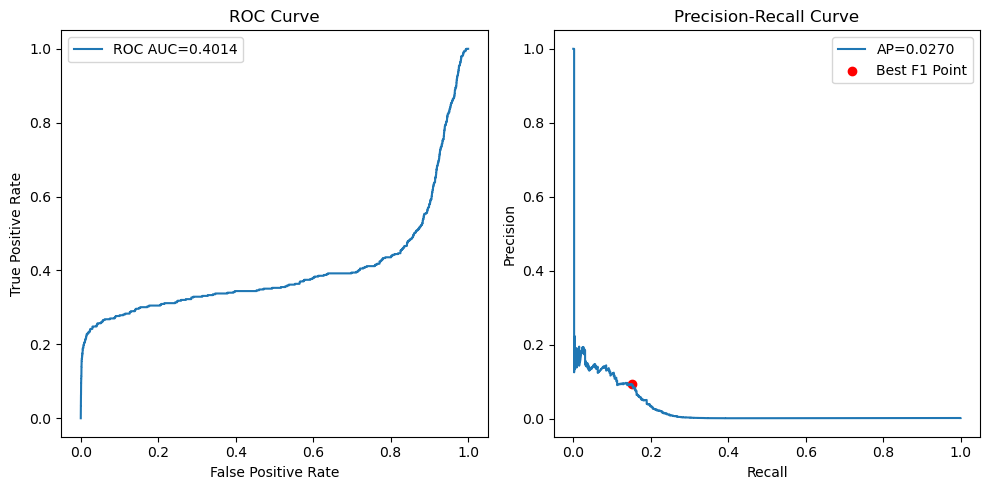

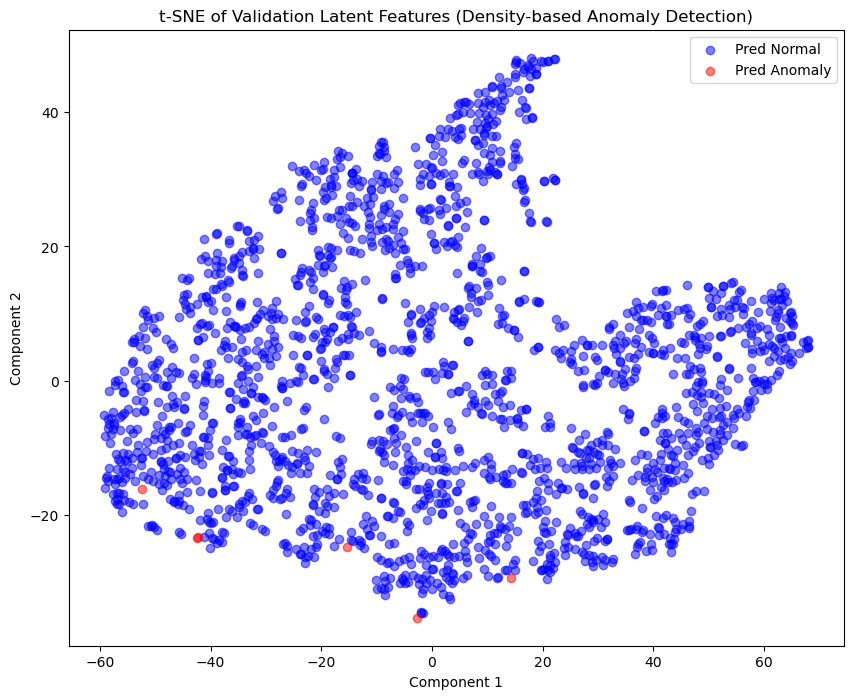

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. 학습 완료된 모델과 전처리된 텐서 등을 기반으로 Latent Feature 추출
train_latent = extract_features(model, x_cat_train_tensor, x_num_train_tensor)
train_latent_np = train_latent.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()

val_latent = extract_features(model, x_cat_val_split, x_num_val_split)
val_latent_np = val_latent.cpu().numpy()
y_val_np = y_val_split_tensor.cpu().numpy()

# 2. Normal 데이터에 대해 Gaussian Mixture Model(GMM)으로 밀도 추정
normal_train_latent = train_latent_np[y_train_np == 0]
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(normal_train_latent)

# 3. Validation 데이터에 대해 log-likelihood 점수 계산 후 anomaly score 산출
log_likelihood = gmm.score_samples(val_latent_np)
anomaly_score = -log_likelihood

# 4. Threshold 자동 선택 (ROC 또는 Precision-Recall 커브 이용)
fpr, tpr, roc_thresholds = roc_curve(y_val_np, anomaly_score, pos_label=1)
precision, recall, pr_thresholds = precision_recall_curve(y_val_np, anomaly_score, pos_label=1)

roc_auc = auc(fpr, tpr)
ap_score = average_precision_score(y_val_np, anomaly_score)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {ap_score:.4f}")

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = pr_thresholds[best_idx]
print(f"Best F1 score on Validation: {f1_scores[best_idx]:.4f} at threshold {best_threshold:.4f}")

pred_anomaly = (anomaly_score > best_threshold).astype(int)

val_precision = precision_score(y_val_np, pred_anomaly, zero_division=0)
val_recall = recall_score(y_val_np, pred_anomaly, zero_division=0)
val_f1 = f1_score(y_val_np, pred_anomaly, zero_division=0)
print(f"Final Validation Performance with chosen threshold:")
print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP={ap_score:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label='Best F1 Point')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# 7. t-SNE 시각화
sample_size = 2000
if len(val_latent_np) > sample_size:
    indices = np.random.choice(len(val_latent_np), size=sample_size, replace=False)
else:
    indices = np.arange(len(val_latent_np))

sample_features = val_latent_np[indices]
sample_labels = y_val_np[indices]
sample_preds = pred_anomaly[indices]

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(sample_features)

normal_tsne = tsne_result[sample_preds == 0]
anomaly_tsne = tsne_result[sample_preds == 1]

plt.figure(figsize=(10,8))
plt.scatter(normal_tsne[:,0], normal_tsne[:,1], c='blue', alpha=0.5, label='Pred Normal')
plt.scatter(anomaly_tsne[:,0], anomaly_tsne[:,1], c='red', alpha=0.5, label='Pred Anomaly')
plt.title('t-SNE of Validation Latent Features (Density-based Anomaly Detection)')
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()